# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
filename = 'dat-coreset'
epochs = 10
batch_size = 4
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [ ]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT RESULT

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [15]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    # print('start query')
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)

    # accelerator.print('got dataloader')
    
    model.eval()
    start_time = time.time()
    embeddings = []

    # accelerator.print('start inf')
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())

    # accelerator.print('finish inf')
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        # print('got distances')
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)

        # print('got threshold')
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend(selected_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6055, Accuracy: 0.8285, F1 Micro: 0.8825, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3994, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3009, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2595, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2438, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2239, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2505, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2275

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5093, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2916, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2334, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1908, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1556, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1219,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4256, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1628, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1506, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.098

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2083, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1902, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1334, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3536, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1811, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1717, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1578, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.136, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1008, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0835, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3417, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1836, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1879, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3249, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1903, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1004, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 8/10, Train Loss: 0.0729, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3081, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.186, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.9631, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1853, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0814, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3009, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.164, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7358
Epoch 10/10, Train Loss: 0.0466, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.286, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.207, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1794, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0468, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2798, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 6/10, Train Loss: 0.0821, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.735
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7266
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.279, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1829, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.9551, F1 Micro: 0.9659, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7274
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7355
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1699, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7376
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7426
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7274
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8209
Epoch 10/10, Train Loss: 0.0405, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2741, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7201
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7003
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7291
Epoch 10/10, Train Loss: 0.0286, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2527, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1869, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1662, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7511
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7166
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7292
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7382
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7368
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9679, F1 Micro: 0.9757, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2636, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1434, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1332, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 5/10, Train Loss: 0.1058, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0812, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7499
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7271
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7918
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1638, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1624, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.131, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 5/10, Train Loss: 0.1024, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7224
Epoch 6/10, Train Loss: 0.0773, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7317
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2584, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1626, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.15, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1146, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1011, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7392
Epoch 6/10, Train Loss: 0.0795, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.72
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7258
Epoch 8/10, Train Loss: 0.0397, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.8017
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.8135
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2547, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1525, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1468, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1306, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.0863, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Epoch 6/10, Train Loss: 0.0706, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7278
Epoch 7/10, Train Loss: 0.0541, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7868
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.782
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2476, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1617, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1431, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1151, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7449
Epoch 7/10, Train Loss: 0.0566, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.7175
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9503, F1 Micro: 0.9627, F1 Macro: 0.7175
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7182
Epoch 10/10, Train Loss: 0.0245, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.247, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1535, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 4/10, Train Loss: 0.128, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6993
Epoch 5/10, Train Loss: 0.0846, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0661, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7629
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7883
Epoch 9/10, Train Loss: 0.0304, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0202, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2436, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1759, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1399, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1235, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0754, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7214
Epoch 6/10, Train Loss: 0.0639, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7154
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7224
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7813
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.786
Epoch 10/10, Train Loss: 0.0228, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2493, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1447, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1238, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1018, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7207
Epoch 6/10, Train Loss: 0.0712, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7139
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0353, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7299
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0332, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7974
Epoch 1

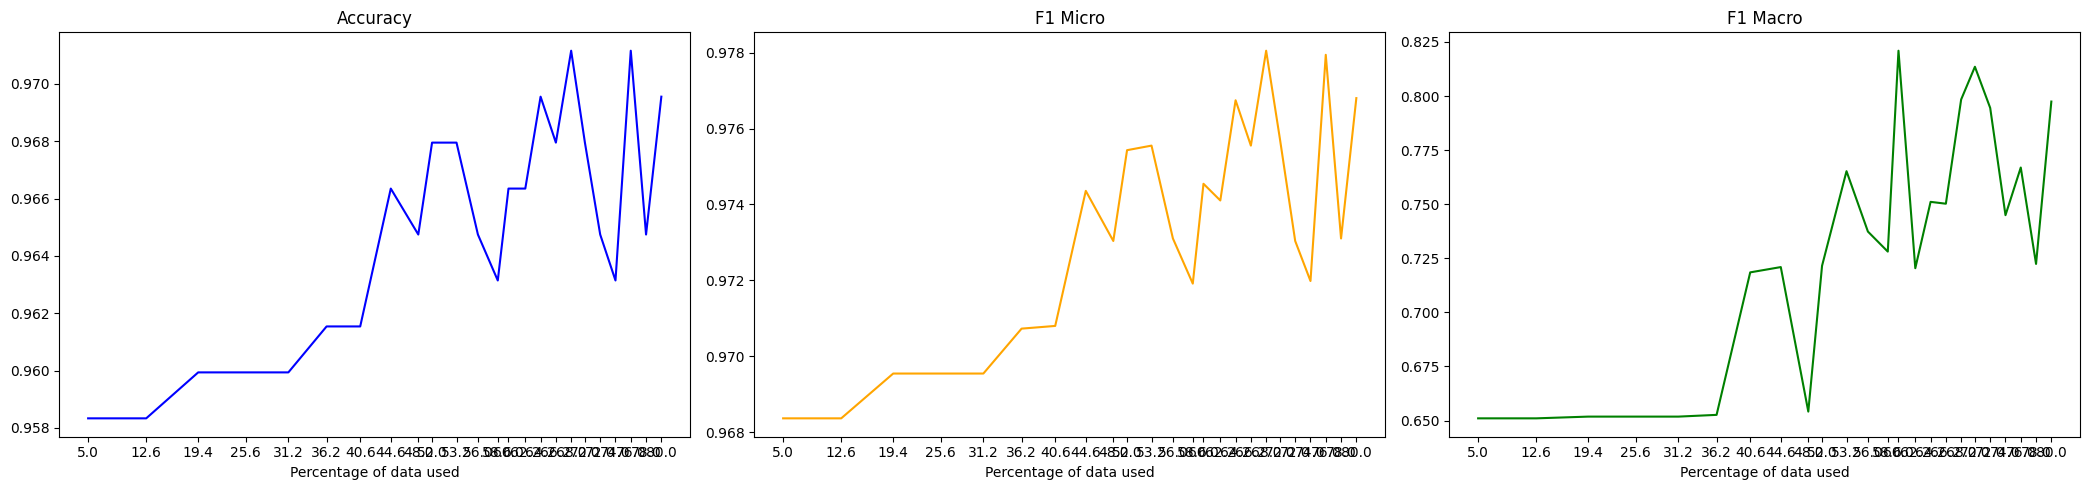

In [18]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6122, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3447, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1488, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1241, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1409,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2041, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1693, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1464, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1261, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1257, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1143,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4122, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2059, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1754, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1184, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.092

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3784, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1827, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1395, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.0955, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0959, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3586, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1738, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1559, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0619, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.325, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1977, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1797, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1526, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6516
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 10/10, Train Loss: 0.0597, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3253, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.204, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0574, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3096, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2003, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7224
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7214
Epoch 10/10, Train Loss: 0.0393, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3204, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1987, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1537, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2837, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1668, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7675
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2736, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7855
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2829, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1632, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.0427, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1538, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1406, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 6/10, Train Loss: 0.078, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8023
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2896, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1856, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7857
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7016
Higher F1 achieved, saving model
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0517, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7882
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9647, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1678, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1056, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0777, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7865
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7009
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.768
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1832, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 5/10, Train Loss: 0.0955, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.719
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7433
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0562, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7864
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0214, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2733, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1551, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1158, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7019
Epoch 5/10, Train Loss: 0.0977, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8328
Epoch 8/10, Train Loss: 0.0278, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7391
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7936
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1669, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1422, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0935, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0733, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.8127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7883
Epoch 8/10, Train Loss: 0.0406, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7967
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8161
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.258, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1845, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1415, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1034, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0682, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7367
Epoch 7/10, Train Loss: 0.055, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7867
Epoch 8/10, Train Loss: 0.0375, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8225
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2353, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1724, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7468
Epoch 7/10, Train Loss: 0.054, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7875
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6957
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0246, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2599, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1738, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1696, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1194, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7031
Epoch 6/10, Train Loss: 0.0679, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0462, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0302, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8124
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2589, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1429, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1061, Accuracy: 0.9551, F1 Micro: 0.9663, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0808, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7368
Epoch 6/10, Train Loss: 0.0567, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0515, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.8119
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0343, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.8143
Higher 

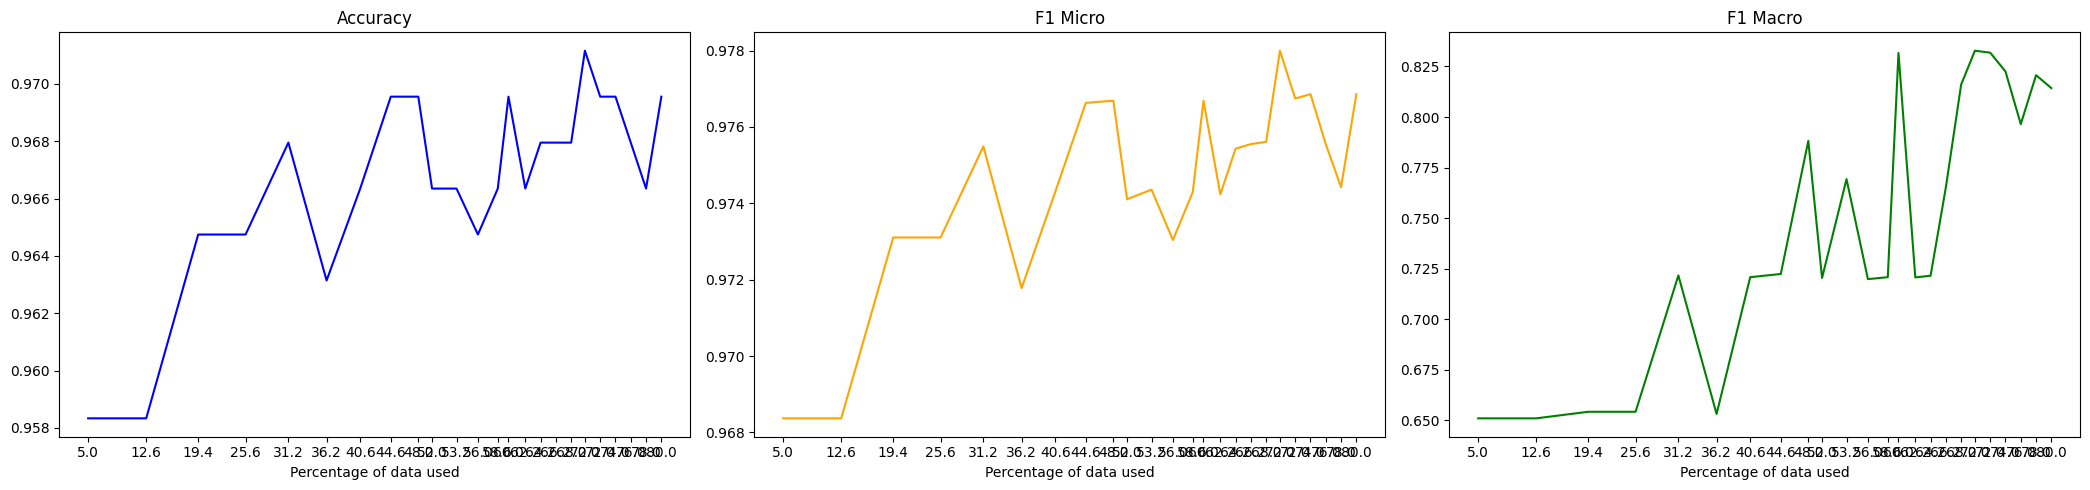

In [19]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.543, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3077, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2069, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.207, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2088, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1517, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0855, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1988, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2041, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1711, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1299, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1499, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2029, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1434, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 8/10, Train Loss: 0.1189, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3479, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1932, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1245, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 8/10, Train Loss: 0.1027, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.6502
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3307, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1694, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1541, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1277, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3317, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2074, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9551, F1 Micro: 0.9653, F1 Macro: 0.6478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3012, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1793, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1666, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7003
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7167
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7924
Epoch 10/10, Train Loss: 0.0399, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2966, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Macro: 0.7162
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7166
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7166
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1662, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1184, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9551, F1 Micro: 0.9657, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0896, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9567, F1 Micro: 0.9662, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7852
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7061
Epoch 10/10, Train Loss: 0.026, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2636, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1774, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1352, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9567, F1 Micro: 0.9667, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.6512
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9583, F1 Micro: 0.9681, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2695, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1766, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1418, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1347, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.752
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9583, F1 Micro: 0.968, F1 Macro: 0.7159
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7097
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8138
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2637, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1679, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1522, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1373, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1022, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0798, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7104
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9663, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2783, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1613, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1522, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1362, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7737
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9679, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 6/10, Train Loss: 0.0882, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.708
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7855
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7871
Epoch 10/10, Train Loss: 0.0332, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2511, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1765, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.136, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7201
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7197
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7189
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7676
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7844
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2527, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1652, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7194
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0464, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7874
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7867
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.262, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1359, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 6/10, Train Loss: 0.0811, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0598, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.785
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.181, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1597, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7876
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Epoch 10/10, Train Loss: 0.0294, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2505, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1618, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1433, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1135, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 6/10, Train Loss: 0.0729, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.7151
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7201
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7647
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2406, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1623, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1575, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0699, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 9/10, Train Loss: 0.0263, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2324, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1662, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1362, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0516, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2353, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.14, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1169, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7662
Epoch 5/10, Train Loss: 0.0903, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7014
Epoch 7/10, Train Loss: 0.0629, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.8294
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.767
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2349, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1684, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1375, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.096, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7226
Epoch 6/10, Train Loss: 0.0653, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7034
Epoch 8/10, Train Loss: 0.037, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7881
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0244, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.772
Epoch 10/10, Train Loss: 0.0254, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2362, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1655, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1364, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1178, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.0863, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0674, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7393
Epoch 7/10, Train Loss: 0.0429, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7686
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8026
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Ma

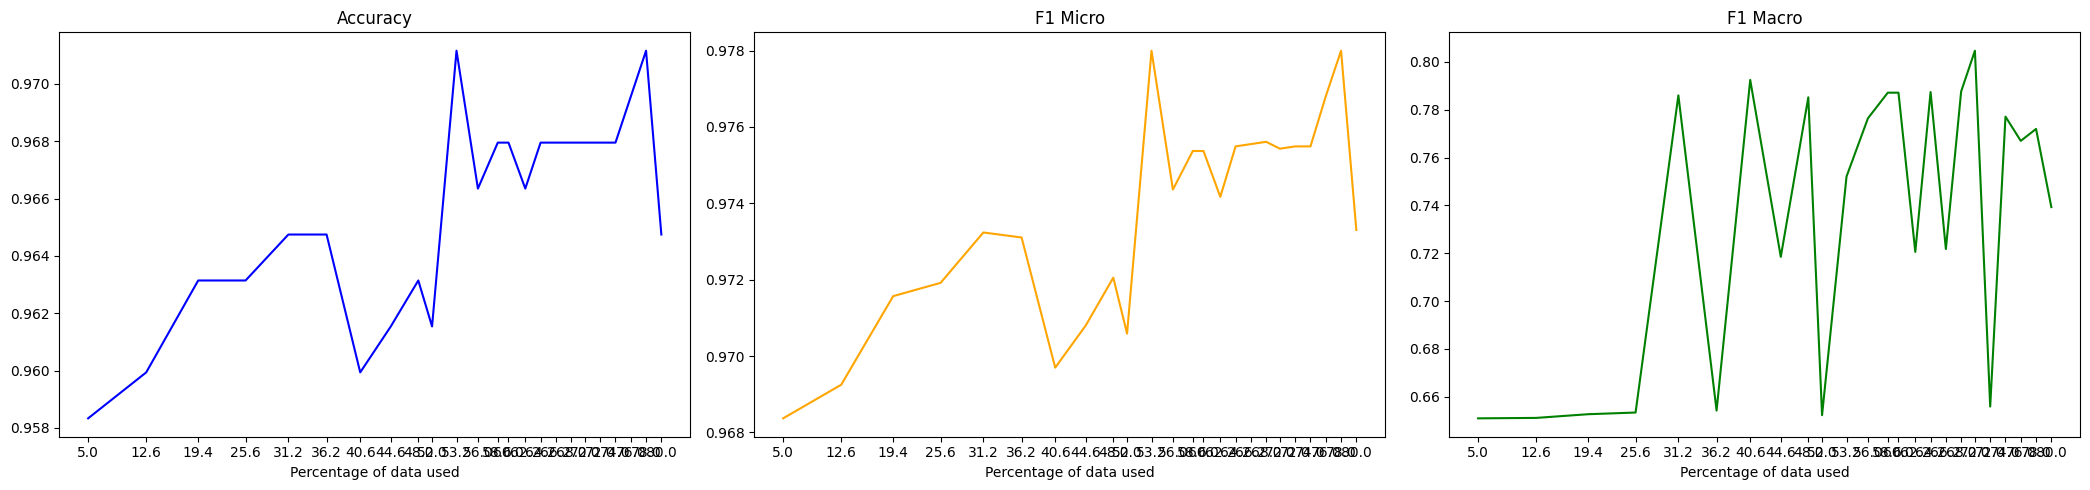

In [20]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.52, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3222, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2236, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2109, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1944, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1271, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1643, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.44, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2591, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1594, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.191, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1325, Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1915, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1719, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1592, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.135, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3352, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2068, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.15, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1668, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1519, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1345, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0975, Accuracy: 0.9647, F1 Micro: 0.9728

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3242, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1773, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1866, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1431, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9631, F1 Micro: 0.9715, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6516
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9599, F1 Micro: 0.9689, F1 Macro: 0.6505
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3046, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.18, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1665, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.14, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6523
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6532
Epoch 10/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2963, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1603, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 8/10, Train Loss: 0.0808, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6532
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 10/10, Train Loss: 0.0505, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2762, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1705, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1515, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0942, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.6499
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2783, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1685, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7657
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9663, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1871, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1446, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6528
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1746, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7071
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9583, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2443, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.03

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.259, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1709, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1642, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7201
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7193
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7767
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7852
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7791
Epoch 10/10, Train Loss: 0.0281, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2562, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1892, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.762
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7635
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.247, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1612, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7932
Epoch 8/10, Train Loss: 0.0528, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.796
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2463, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8303
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8285
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8285
Epoch 10/10, Train Loss: 0.0222, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2351, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1687, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1614, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6517
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7174
Epoch 7/10, Train Loss: 0.0622, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.809
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0397, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7969
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7364
Epoch 10/10, Train Loss: 0.0244, Accuracy: 0.9631, F1 Micro: 0.972, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2448, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1608, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1342, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.081, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7958
Epoch 7/10, Train Loss: 0.0509, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.8287
Epoch 8/10, Train Loss: 0.0384, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7635
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0242, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2441, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1769, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1677, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1428, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.101, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.8089
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7901
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0414, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8133
Epoch 9/10, Train Loss: 0.024, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7625
Epoch 10/10, Train Loss: 0.0214, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2307, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1488, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1528, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.727
Epoch 6/10, Train Loss: 0.078, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7916
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.8022
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.8189
Epoch 9/10, Train Loss: 0.0305, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8014
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2337, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1717, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0987, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7372
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7309
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.033, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8616
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8293
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2218, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1553, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1451, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1313, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1042, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8288
Epoch 7/10, Train Loss: 0.0555, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7918
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0206, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7491
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2235, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.167, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1667, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.084, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0431, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7378
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.8317
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9631, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2315, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.175, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1641, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.0942, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0758, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7626
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7193
Epoch 9/10, Train Loss: 0.031, Accuracy: 0.9567, F1 Micro: 0.967, F1 Macro: 0.7179
Epoch 10/10, Train Loss: 0.0196, Accuracy: 0.

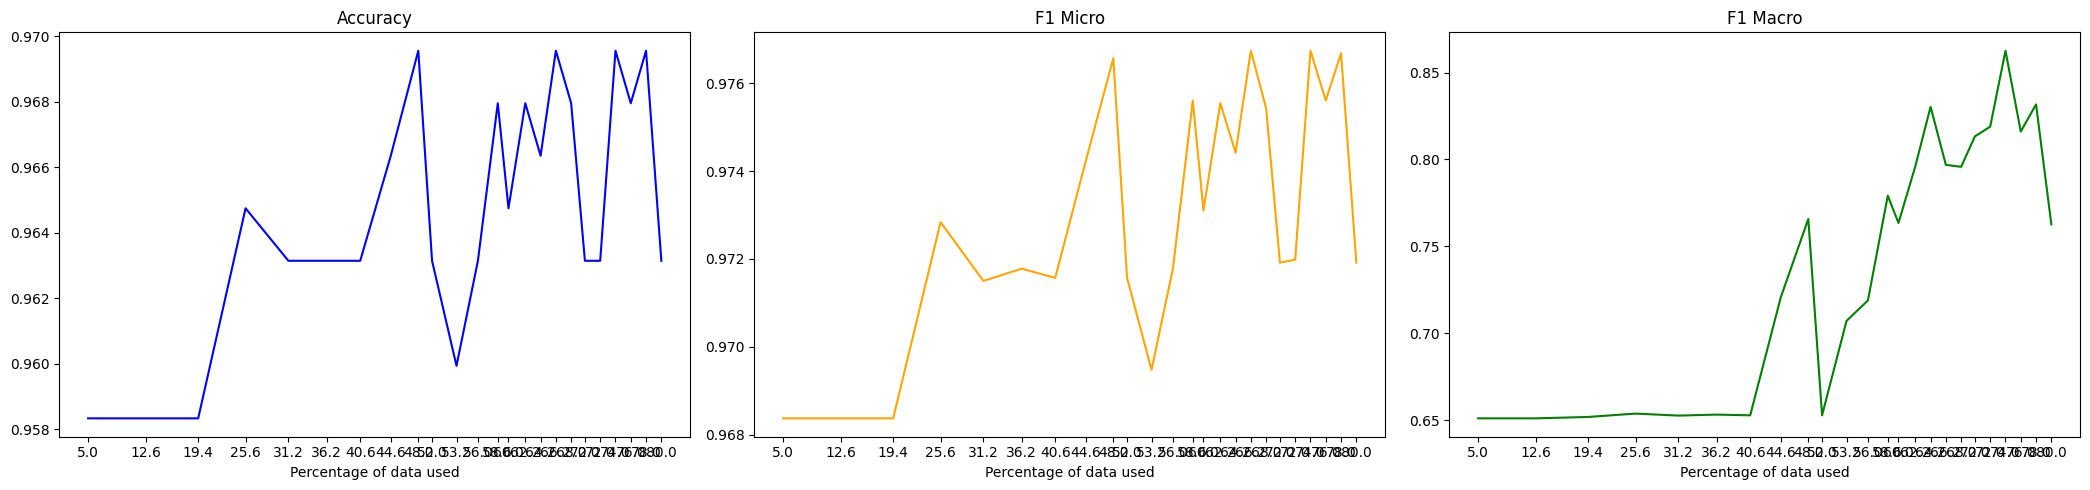

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.305, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.238, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1601, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1158, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1323, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1665, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4747, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1686, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1452, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1205,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2012, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1749, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1512, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1568, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.108, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.0943, Accuracy: 0.9615, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1945, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1683, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1206, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1074, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6519
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3414, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2254, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.149, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1706, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1456, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 8/10, Train Loss: 0.1078, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1087, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3225, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1967, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6525
Epoch 5/10, Train Loss: 0.1463, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1327, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Epoch 7/10, Train Loss: 0.1152, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 9/10, Train Loss: 0.0704, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 10/10, Train Loss: 0.0547, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2936, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1825, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1628, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.6523
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6548
Epoch 7/10, Train Loss: 0.095, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2864, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1913, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.052

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2742, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1704, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.73
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6541
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1803, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7218
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2851, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1662, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.127, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7209
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2733, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1607, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1658, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.6538
Epoch 5/10, Train Loss: 0.1302, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1122, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.752
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6558
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7213
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7225
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2758, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1896, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0813, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7234
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.6556
Epoch 9/10, Train Loss: 0.0391, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7225
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2473, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1908, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1448, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.6558
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7175
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.655
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7813
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2382, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1613, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1588, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1257, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.08, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7206
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.8043
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7875
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9696, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1799, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1776, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1046, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.656
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7156
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0514, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7958
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7292
Epoch 10/10, Train Loss: 0.0249, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2488, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1855, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1335, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1323, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.1037, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7194
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0799, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7393
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7401
Epoch 10/10, Train Loss: 0.0223, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2389, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1702, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1554, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7661
Epoch 7/10, Train Loss: 0.0557, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.031, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.778
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0265, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2448, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.169, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Epoch 5/10, Train Loss: 0.0992, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 6/10, Train Loss: 0.0753, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0538, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8124
Epoch 8/10, Train Loss: 0.0403, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7206
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0281, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0238, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2352, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7291
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7798
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2346, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1562, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0706, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0526, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.033, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.8206
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9631, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2395, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1458, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1454, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1153, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.749
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7194
Epoch 6/10, Train Loss: 0.0677, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7215
Epoch 7/10, Train Loss: 0.0522, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0337, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8315
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 10/10, Train Loss: 0.0237, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2303, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1715, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1447, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1213, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1012, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7312
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0736, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0489, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.8224
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8328
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.244, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1589, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1455, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7451
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7274
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0342, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8133
Epoch 9/10, Train Loss: 0.0241, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.754
Epoch 10/1

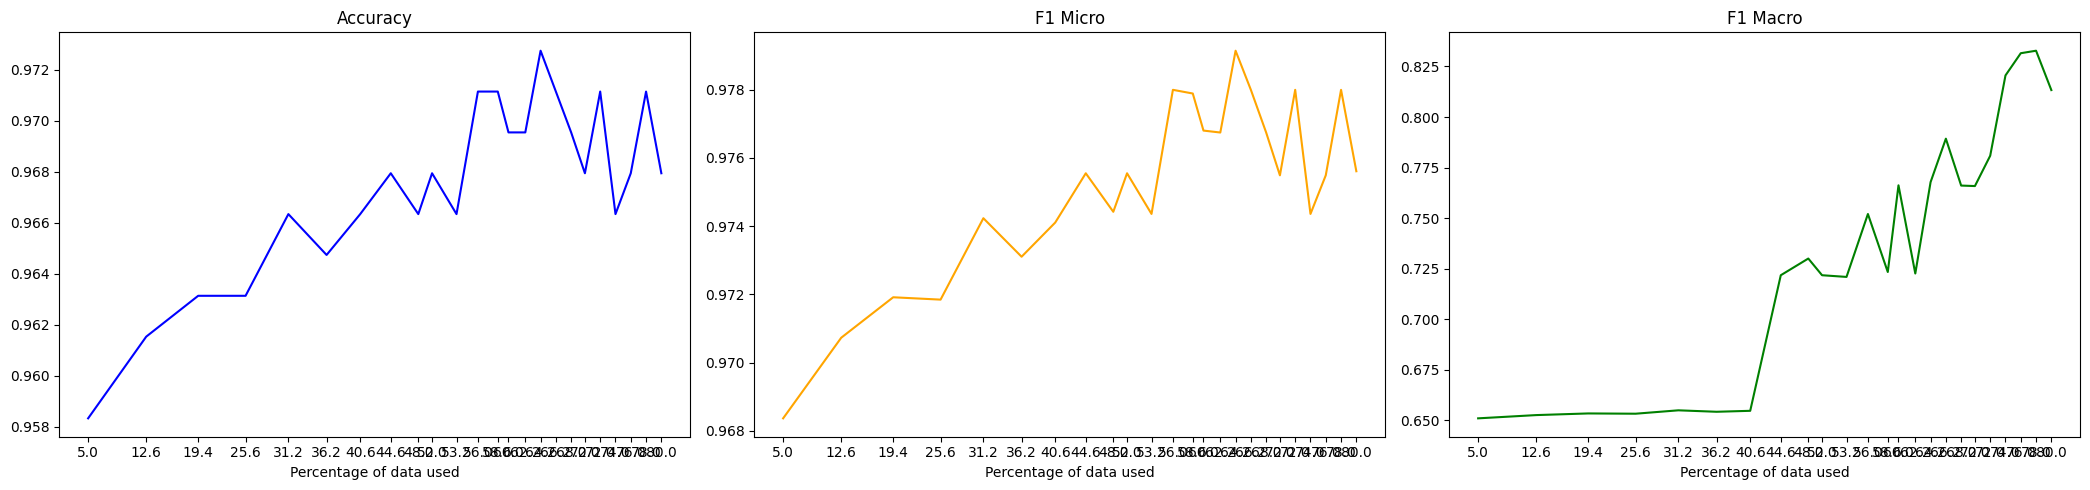

In [ ]:
active_learning(seeds[4], 4)